## 1. Maryland crime data
<p>Crime rates change and can vary across space and time. Reasons and even trends can be difficult to detect, due to many complex factors driving crime. Despite this uncertainty, policymakers need to know if crime rates are changing to inform their decisions.</p>
<p>We will explore <a href="http://goccp.maryland.gov/crime-statistics/">crime statistics</a> collected between 1975 and 2016 from the State of Maryland. We will see if linear trends exist in crime rates across Maryland. This data comes from the <a href="https://ccjs.umd.edu/research/maryland-data-analysis-center">Maryland Statistical Analysis Center</a>. </p>
<p>We will use regression analysis because it allows estimation of linear trends. But, some datasets can be hierarchical or nested, which presents a regression challenge. Many government statistics, such as crime rates, come from nested datasets. For example, counties exist within most US states (Alaska has “burrows,” and  Louisiana has “parishes”).  Counties and county-level governments vary even within the same state.  For example, one county might have a high population density and be urban whereas a second county might have a low population density and be rural. </p>
<p>Hierarchical modeling allows us to capture and model this hierarchy. This figure shows the counties and their populations in Maryland. We will create a similar figure for their crime trends at the end of this project.</p>
<p><img src="https://assets.datacamp.com/production/project_673/./img/countyPop.jpg" alt="Map of Maryland counties and population"></p>
<p>Before running a regression analysis, we often need to tidy data. Everyday tidying tasks include renaming and reformatting columns. Luckily, the <a href="https://www.tidyverse.org/">Tidyverse</a> exists!</p>

In [20]:
# Load the packages
library(tidyverse)
library(lubridate)

# Read in the crime data
crime_raw <- read_csv("datasets/Violent_Crime_by_County_1975_to_2016.csv")

# Select and mutate columns the needed columns
crime_use <- crime_raw %>% 
    select(JURISDICTION, YEAR, POPULATION, crime_rate = `VIOLENT CRIME RATE PER 100,000 PEOPLE`) %>%
    mutate(YEAR_2 = year(mdy_hms(YEAR)))

# Peek at the data
head(crime_use)

Parsed with column specification:
cols(
  .default = col_double(),
  JURISDICTION = col_character(),
  YEAR = col_character()
)
See spec(...) for full column specifications.


JURISDICTION,YEAR,POPULATION,crime_rate,YEAR_2
Allegany County,01/01/1975 12:00:00 AM,79655,178.3,1975
Allegany County,01/01/1976 12:00:00 AM,83923,103.7,1976
Allegany County,01/01/1977 12:00:00 AM,82102,154.7,1977
Allegany County,01/01/1978 12:00:00 AM,79966,127.6,1978
Allegany County,01/01/1979 12:00:00 AM,79721,138.0,1979
Allegany County,01/01/1980 12:00:00 AM,80461,147.9,1980


## 2. Raw data and trend lines
<p>We have now loaded and tidied our data. Before running a regression or building a model, I like to visualize the data. Plotting the data helps me see what is going on with the data and tell the data's story. A plot like this, after a little cleanup, would likely be in a final report on crime statistics. A picture (or well-designed figure!) can be worth a thousand words!</p>
<p>Now, let's plot the crime rate over time for each county and add a linear trend line.</p>

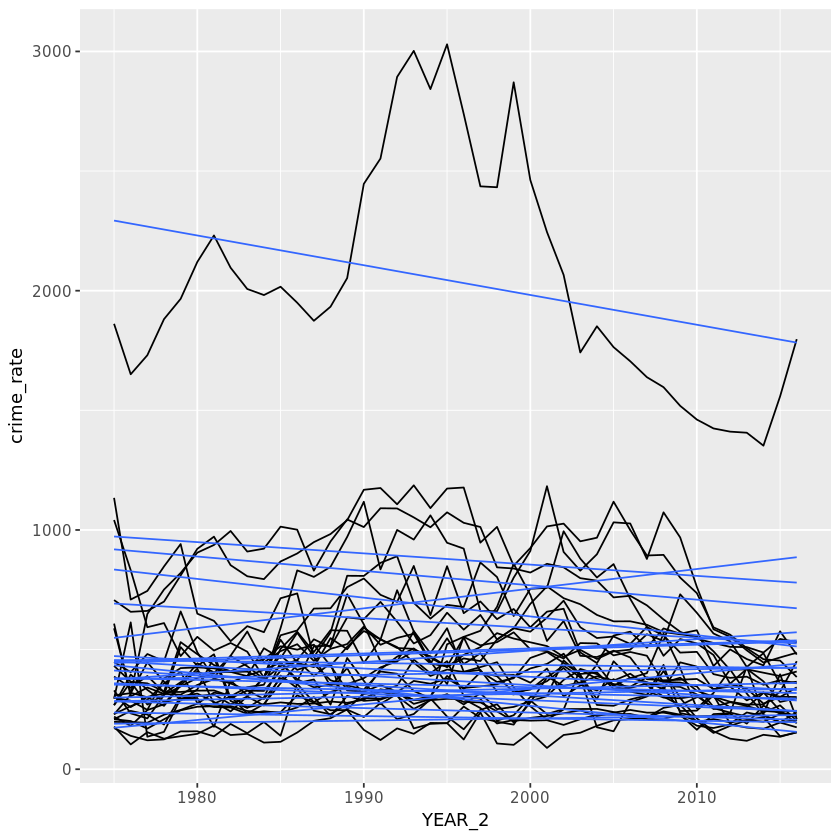

In [22]:
# Plot the data as lines and linear trend lines
ggplot(crime_use, aes(x = YEAR_2, y = crime_rate, group = JURISDICTION)) + 
    geom_line() + 
    stat_smooth(method = "lm", se = FALSE, size = 0.5)

## 3.  Build a lmer() model
<p>Now we can build a hierarchical model, also known as a linear mixed-effects regression model, using <code>lmer()</code>. <code>lmer()</code> uses similar syntax as <code>lm()</code>, but it also requires a random-effect argument. For example, <code>y</code> predicted by fixed-effect slope <code>x</code> and random-effect intercept <code>group</code> would be <code>y ~ x + (1|group)</code>. <code>x</code> can also be included as a random-effect slope: <code>y ~ x + (x|group)</code>. <a href="https://www.datacamp.com/courses/hierarchical-and-mixed-effects-models">Hierarchical and Mixed Effect Models</a> covers these models in greater detail.</p>
<p>In our case, we wonder if a linear trend through time predicts crime rates. We will estimate a trend for the entire state (a fixed-effect slope) and trends for each county (random-effect slopes). By treating each county as a random-effect, we assume the trend for each county comes from a state-wide distribution. </p>
<p>I use the <code>lmerTest</code> package because it adds <em>p</em>-values for fixed-effect coefficients to <code>lmer()</code> models, something the <code>lme4</code> package does not include for <a href="http://bbolker.github.io/mixedmodels-misc/glmmFAQ.html#why-doesnt-lme4-display-denominator-degrees-of-freedomp-values-what-other-options-do-i-have">reasons listed on the project's FAQ page</a>. </p>

In [24]:
# Load lmerTest package
library(lmerTest)

# Run a lmer() on data, notice the warning message
lmer_fail <- lmer(formula = crime_rate ~ YEAR_2 + (YEAR_2|JURISDICTION), data = crime_use)

# Print the model's output
print(lmer_fail)

singular fit


Linear mixed model fit by REML ['lmerModLmerTest']
Formula: crime_rate ~ YEAR_2 + (YEAR_2 | JURISDICTION)
   Data: crime_use
REML criterion at convergence: 13217.68
Random effects:
 Groups       Name        Std.Dev.  Corr
 JURISDICTION (Intercept) 172.64950     
              YEAR_2        0.09589 1.00
 Residual                 160.71957     
Number of obs: 1008, groups:  JURISDICTION, 24
Fixed Effects:
(Intercept)       YEAR_2  
   3342.520       -1.425  
convergence code 0; 1 optimizer warnings; 0 lme4 warnings 


## 4. Re-scale the data
<p>In the last section, we got a warning message, <code>singular fit</code>, as well as more text in the model output: <code>convergence code 0; 1 optimizer warnings; 0 lme4 warnings</code>.  The output tells us that <code>lmer()</code> was unable to fit the data to the model. When this happens, I double check my input data and model formula.</p>
<p>In our case, the warning occurs because of the intercept estimates. Specifically, regression models work best when the intercept is near zero. With our data, <code>Year_2</code> goes from 1976 to 2016. 1976 is far from zero, relative to the data, making the model numerically unstable. We need to rescale <code>YEAR_2</code> by changing <code>Year_2</code> to start at zero, rather than 1976. </p>
<p>After we do this, we can rebuild the model using the new slope predictor variable.</p>

In [26]:
# Mutate data to create another year column, YEAR_3
crime_use <-
  crime_use %>%
    mutate(YEAR_3 = YEAR_2 - min(YEAR_2))

# Run a lmer() on mutuated data 
(lmer_crime <- lmer(formula = crime_rate ~ YEAR_3 + (YEAR_3|JURISDICTION), data = crime_use))

Linear mixed model fit by REML ['lmerModLmerTest']
Formula: crime_rate ~ YEAR_3 + (YEAR_3 | JURISDICTION)
   Data: crime_use
REML criterion at convergence: 13144.44
Random effects:
 Groups       Name        Std.Dev. Corr 
 JURISDICTION (Intercept) 427.846       
              YEAR_3        4.235  -0.69
 Residual                 152.125       
Number of obs: 1008, groups:  JURISDICTION, 24
Fixed Effects:
(Intercept)       YEAR_3  
    529.031       -1.425  

## 5. Model outputs
<p>After building the model, we can examine the model's output using <code>summary()</code>. <code>lmer()</code> outputs are similar to the outputs from <code>lm()</code>. But, <code>lmer()</code> outputs include extra details including both fixed- and random-effects. The <a href="https://www.datacamp.com/courses/hierarchical-and-mixed-effects-models">Hierarchical and Mixed-effects Models course</a> provides more information on <code>lmer()</code> summary outputs. </p>
<p>The fixed-effect trend for <code>YEAR_3</code> is not significantly different from zero, but what do the estimates look like for different counties?  We can also access the regression coefficients using <code>fixef()</code> and <code>ranef()</code>. </p>

In [28]:
# Examine the model outputs using summary
summary(lmer_crime)

# This is for readability 
noquote("**** Fixed-effects ****")

# Use fixef() to view fixed-effects
fixef(lmer_crime)

# This is for readability 
noquote("**** Random-effects ****")

# Use ranef() to view random-effects
ranef(lmer_crime)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: crime_rate ~ YEAR_3 + (YEAR_3 | JURISDICTION)
   Data: crime_use

REML criterion at convergence: 13144.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.4466 -0.4675 -0.0546  0.4328  6.5169 

Random effects:
 Groups       Name        Variance  Std.Dev. Corr 
 JURISDICTION (Intercept) 183052.41 427.846       
              YEAR_3          17.93   4.235  -0.69
 Residual                  23141.94 152.125       
Number of obs: 1008, groups:  JURISDICTION, 24

Fixed effects:
            Estimate Std. Error       df t value Pr(>|t|)    
(Intercept) 529.0308    87.8397  23.0001   6.023 3.84e-06 ***
YEAR_3       -1.4246     0.9506  23.0000  -1.499    0.148    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
       (Intr)
YEAR_3 -0.660

[1] **** Fixed-effects ****

(Intercept)      YEAR_3 
 529.030782   -1.424551

[1] **** Random-effects ****

$JURISDICTION
                       (Intercept)       YEAR_3
Allegany County         -324.40279   6.38773189
Anne Arundel County     -125.56798   4.81452725
Baltimore City          1751.63637 -10.69297722
Baltimore County         376.31193  -3.94824284
Calvert County          -132.90675  -1.82528994
Caroline County         -143.09958   2.15638117
Carroll County          -297.05247   0.75044023
Cecil County             -68.66563   2.77901515
Charles County           -60.79521   2.70968862
Dorchester County        154.05777  -2.19190576
Frederick County         -67.79590  -1.42734755
Garrett County          -335.53249   2.19623911
Harford County          -179.92000   0.25555894
Howard County           -123.98283  -3.82367106
Kent County             -220.62748   2.49301918
Montgomery County       -253.86110   0.03512392
Prince George's County   437.96789  -3.06292844
Queen Anne's County     -181.20167  -0.78720553
Somerset County          -71.53295   0.55554707
St. Mary's County       -1

## 6. Format model coefficients
<p>We estimated a trend for the entire state as a fixed-effect. This is the average trend across all of Maryland. We estimated a trend for each county as a random-effect. The specific random-effect slope estimated for each county is the difference for the county compared to the state average. For example, Allegany County had a slope estimate of 6.4 and Maryland had a slope estimate of -1.4. Adding these together, we get an estimated slope of 5.0 \(6.4 + -1.4 = 5.0\) for Allegany County. </p>
<p>We can use R to calculate the slope estimate for each county by extracting the fixed-effect estimate and adding it to the random-effect estimates. </p>

In [41]:
# Add the fixed-effect to the random-effect and save as county_slopes
county_slopes <- fixef(lmer_crime)["YEAR_3"] + ranef(lmer_crime)$JURISDICTION["YEAR_3"]


# Add a new column with county names
(county_slopes <-
    county_slopes %>% 
        rownames_to_column("county"))

county,YEAR_3
Allegany County,4.9631806
Anne Arundel County,3.3899760
Baltimore City,-12.1175285
Baltimore County,-5.3727941
Calvert County,-3.2498412
Caroline County,0.7318299
Carroll County,-0.6741111
Cecil County,1.3544639
Charles County,1.2851373
Dorchester County,-3.6164570


## 7. Maryland map data
<p>We now have the crime trend data ready, but we need to get map data for the plot.  </p>
<p>I use the <a href="https://cran.r-project.org/web/packages/usmap/"><code>usmap</code></a> package to get map data for the US because the package gives output directly in data frames. The older, <a href="https://cran.r-project.org/web/packages/maps/"><code>maps</code></a> package contains data for the entire world but requires some wrangling to use with <code>ggplot2</code>.</p>

In [37]:
# Load usmap package
library(usmap)

# load and filter map data
county_map <- us_map(regions = "counties", include = "MD")

## 8. Matching county names
<p>We need to make sure the crime data (supplied by the State of Maryland) and the map data (provided in the <code>usmap</code> package) use the same county names. This will allow us to merge the two data frames. In this case, we are lucky and only have one small difference.</p>

In [44]:
# See which counties are not in both datasets
county_slopes %>% anti_join(county_map, by = "county")
county_map %>% anti_join(county_slopes, by = "county")

# Rename crime_names county
county_slopes  <- county_slopes  %>% 
  mutate(county = ifelse(county == "Baltimore City", "Baltimore city", county))

county,YEAR_3
Baltimore City,-12.11753


long,lat,order,hole,piece,group,fips,abbr,full,county
1971953,-346337.0,22832,FALSE,1,24510.1,24510,MD,Maryland,Baltimore city
1973112,-344910.4,22833,FALSE,1,24510.1,24510,MD,Maryland,Baltimore city
1978638,-343296.4,22834,FALSE,1,24510.1,24510,MD,Maryland,Baltimore city
1986523,-340965.4,22835,FALSE,1,24510.1,24510,MD,Maryland,Baltimore city
1988768,-349066.3,22836,FALSE,1,24510.1,24510,MD,Maryland,Baltimore city
1991099,-357567.7,22837,FALSE,1,24510.1,24510,MD,Maryland,Baltimore city
1987283,-360072.8,22838,FALSE,1,24510.1,24510,MD,Maryland,Baltimore city
1980793,-357040.2,22839,FALSE,1,24510.1,24510,MD,Maryland,Baltimore city
1979316,-356705.1,22840,FALSE,1,24510.1,24510,MD,Maryland,Baltimore city
1976962,-356117.7,22841,FALSE,1,24510.1,24510,MD,Maryland,Baltimore city


## 9. Merging data frames
<p>Finally, both data frames now have the same county names. Now we can merge them!</p>

In [45]:
# Merge the map and slope data frames
both_data <- 
  full_join(county_map, county_slopes, by = "county")

# Peek at the data
head(both_data)

long,lat,order,hole,piece,group,fips,abbr,full,county,YEAR_3
1775008,-387237.8,22297,FALSE,1,24001.1,24001,MD,Maryland,Allegany County,4.963181
1779953,-357902.4,22298,FALSE,1,24001.1,24001,MD,Maryland,Allegany County,4.963181
1789820,-355286.0,22299,FALSE,1,24001.1,24001,MD,Maryland,Allegany County,4.963181
1796777,-353431.8,22300,FALSE,1,24001.1,24001,MD,Maryland,Allegany County,4.963181
1824941,-345915.7,22301,FALSE,1,24001.1,24001,MD,Maryland,Allegany County,4.963181
1828029,-345083.7,22302,FALSE,1,24001.1,24001,MD,Maryland,Allegany County,4.963181


## 10. Mapping trends
<p>Woohoo! Now we're ready to plot!</p>
<p>After creating the plot, let's see if any patterns emerge.  </p>

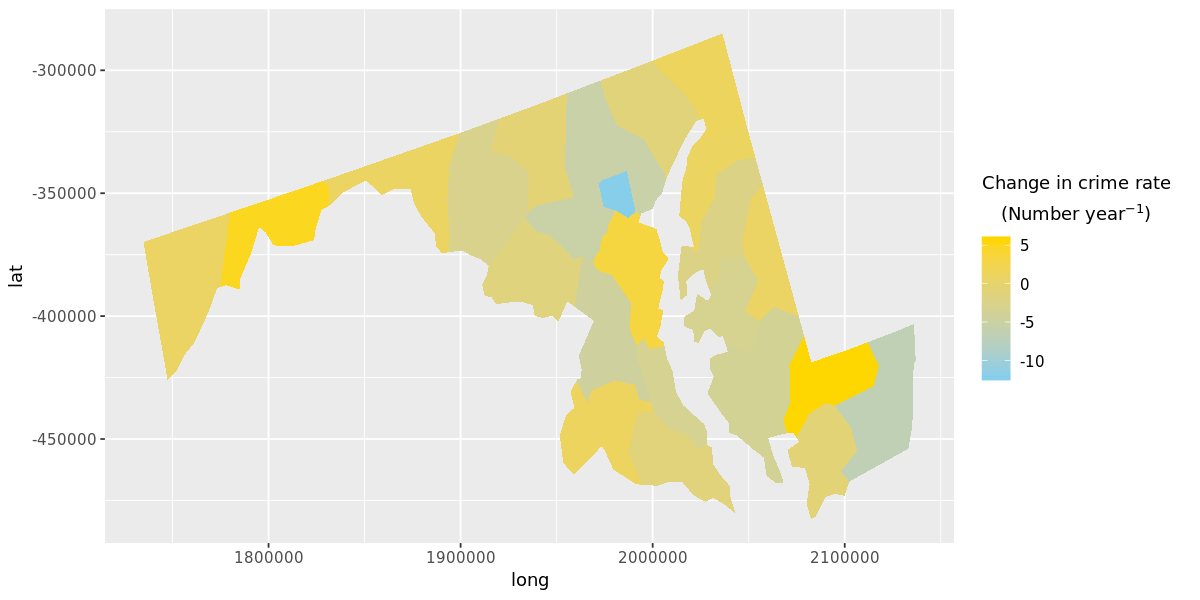

In [46]:
# Set the notebook's plot settings
options(repr.plot.width=10, repr.plot.height=5)

# Plot the results 
crime_map <- 
   ggplot(data = both_data, aes(x = long, y = lat, group = county, fill = YEAR_3)) +
       geom_polygon() + 
       scale_fill_continuous(name = expression(atop("Change in crime rate","(Number year"^-1*")")),
                        low = "skyblue", high = "gold")

# Look at the map
crime_map

## 11. Polish the map
<p>We are almost done. Our map shows how linear trends in crime rates varied between 1976 and 2016, but we do not have a figure to show to policymakers yet.</p>
<p>Let's clean up our plot so that we can present it policymakers.</p>

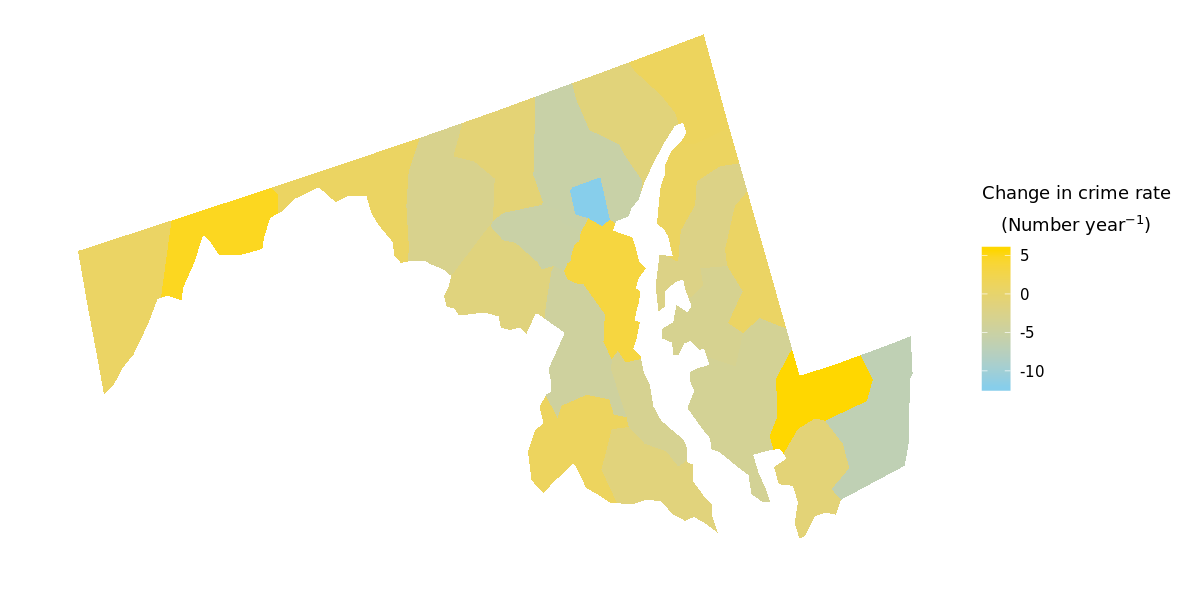

In [49]:
# Plot options
options(repr.plot.width=10, repr.plot.height=5)

# Polish figure
crime_map_final <- crime_map + 
  theme_minimal() +
  xlab("") +
  ylab("") +
  theme(axis.line = element_blank(),
        axis.text = element_blank(),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), 
        panel.border = element_blank(),
        panel.background = element_blank())

# Look at the map
print(crime_map_final)

## 12. Compare populations and crime rates
<p><img src="https://assets.datacamp.com/production/project_673/./img/countyPop.jpg" width="45%" align="left"><img src="https://assets.datacamp.com/production/project_673/./img/crime_map.jpg" width="46%"></p>
<p>Statewide, we found no linear trend in crime across Maryland. But, trends in crime rates varied across the state. What should we tell a policy maker? I would say to them <strong>Location is key</strong>. Some locations have had increasing crime while others have had decreasing crime.  </p>
<p>Our analysis raises other question as well. Comparing the population figure to the crime trends figure, I see that population might impact crime rate trends. Other predictor variables might explain a counties crime rate. We could look for more explanatory variables in public data sources such those supplied by the <a href="https://planning.maryland.gov/msdc/Pages/default.aspx">State of Maryland</a>, the US Federal Government at <a href="https://www.data.gov">Data.gov</a>, and <a href="https://www.census.gov/data.html">the US Census Bureau</a>.</p>
<p>Also, our figure of trends through time suggests a non-linear trend, at least in some counties. We could either use a non-linear model or the only model the crime rate for the past 10 or 20 years. <a href="https://www.datacamp.com/courses/nonlinear-modeling-in-r-with-gams">Nonlinear modeling in R with GAMS</a> covers some non-linear models. Additionally, we could build our own, more complicated regression using a language such as JAGS, covered in <a href="https://www.datacamp.com/courses/bayesian-modeling-with-rjags">Bayesian Modeling with RJAGS</a>. The last model approach would also allow us to calculate credible intervals around the random-effects. </p>
<p>To finish up, we'll quickly look to see if the population by county impacts the crime rate.</p>

In [50]:
# Build a lmer with both year and population
lmer_pop <- lmer(formula = crime_rate ~ YEAR_3 + POPULATION + (YEAR_3|JURISDICTION), data = crime_use)

# Inspect the results
summary(lmer_pop)
ranef(lmer_pop)

Warning message:
"Some predictor variables are on very different scales: consider rescaling"Warning message:
"Some predictor variables are on very different scales: consider rescaling"

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: crime_rate ~ YEAR_3 + POPULATION + (YEAR_3 | JURISDICTION)
   Data: crime_use

REML criterion at convergence: 13160.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.4503 -0.4656 -0.0545  0.4325  6.5160 

Random effects:
 Groups       Name        Variance Std.Dev. Corr 
 JURISDICTION (Intercept) 188653.8 434.343       
              YEAR_3          18.3   4.278  -0.68
 Residual                  23136.1 152.106       
Number of obs: 1008, groups:  JURISDICTION, 24

Fixed effects:
              Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)  5.338e+02  9.279e+01  2.179e+01   5.753 9.02e-06 ***
YEAR_3      -1.363e+00  1.015e+00  2.638e+01  -1.343    0.191    
POPULATION  -2.883e-05  1.549e-04  3.077e+01  -0.186    0.854    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
           (Intr) YEAR_3
YEAR_3     -0.505 

$JURISDICTION
                       (Intercept)      YEAR_3
Allegany County         -327.79962   6.3680635
Anne Arundel County     -120.43136   4.9094623
Baltimore City          1769.97707 -10.8711791
Baltimore County         390.51088  -3.9126966
Calvert County          -136.76125  -1.8463195
Caroline County         -147.77350   2.1305489
Carroll County          -299.22806   0.7487660
Cecil County             -72.44335   2.7828567
Charles County           -64.21218   2.7378129
Dorchester County        149.89391  -2.2383548
Frederick County         -69.52330  -1.3972294
Garrett County          -339.92906   2.1554975
Harford County          -180.66967   0.2736064
Howard County           -125.04570  -3.7786450
Kent County             -225.45766   2.4608621
Montgomery County       -241.26907   0.2374423
Prince George's County   452.51630  -2.9877349
Queen Anne's County     -185.39495  -0.8270734
Somerset County          -76.16270   0.5202059
St. Mary's County       -155.79029   0.1308995